### Imports, datasets and helper functions

In [1]:
from datetime import date, timedelta, datetime
from math import radians, cos, sin, asin, sqrt

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

In [2]:
df = pd.read_csv("./../data_temp/training_transformed.csv")
df = df.set_index("geohash6")
df.columns = pd.DatetimeIndex(df.columns)
df = df.replace(-1, -0.1) # visual purpose only

In [4]:
# Helper functions

def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

def get_timespan_15(df, startTime, endTime, freq='15min'):
    return df[pd.date_range(startTime, endTime, freq=freq)] # inclusive

### EDA

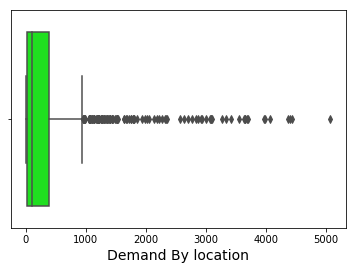

geohash6
qp02zg    103.705239
dtype: float64

In [7]:
# Sum over time period per location
# Heavy skew to left (demand = 0.000926), mean=332, trailing tail after demand=387 (75th-percentile), until demand=5079
# SD: 609

df_sum = df.sum(axis=1)
sns.boxplot(x=df_sum.values, color='lime')
plt.xlabel('Demand By location', fontsize=14)
plt.show()

# 5 locations with lowest total demand: qp09t7, qp0d4m, qp08fs, qp03yn, qp09mv
# 5 locations with highest total demand: qp03yb, qp03xw, qp03xx, qp09e5, qp09d9
# Median: qp02zg (total demand: 103.7)

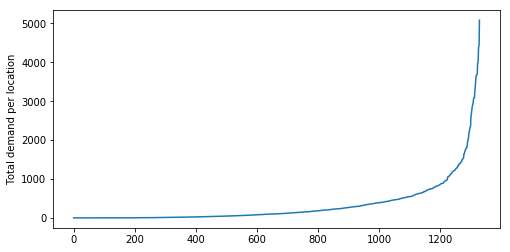

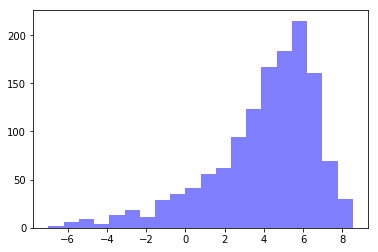

In [18]:
# Line graph of total demand vs place-id (sorted)

plt.figure(figsize=(8,4))
plt.ylabel('Total demand per location')
y = df_sum.sort_values(ascending=True).values
x = [x for x in range(0, len(y))]

plt.plot(x,y)
plt.show()

# histogram (log values)
# histogram on original values doesnt show much
n, bins, patches = plt.hist(np.log(df_sum), 20, facecolor='blue', alpha=0.5)
plt.show()

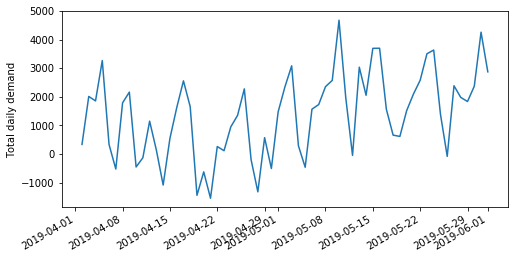

In [104]:
# Total demand vs time (daily) (identify trend and seasonality)
# stable trend (slight dip, then slight climb), weekly seasonality

df = df.replace(np.nan, -0.1) # visual purpose only

end_date = date(2019, 6, 1)
period = 61

df_daily = df.sum(axis=0).resample('D').sum() # resample daily # Also: mean() etc

plt.figure(figsize=(8,4))
plt.ylabel('Total daily demand')
y = get_timespan(df_daily, end_date, period, period).values.flatten()
x = [end_date - timedelta(days=x) for x in range(0, period)]
x.reverse()

plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.show()

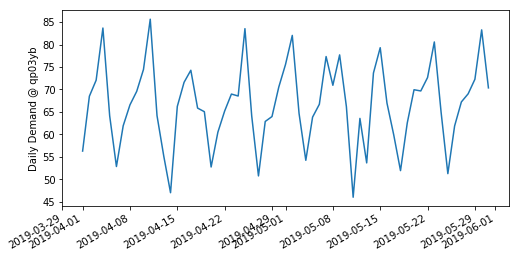

In [103]:
# Total demand per location over time (days)

df = df.replace(np.nan, -0.1) # visual purpose only

geohashStr = 'qp03yb'
end_date = date(2019, 6, 1)
period = 61

plt.figure(figsize=(8,4))
plt.ylabel('Daily Demand @ {}'.format(geohashStr))
single_resampled = df[df.index==geohashStr].transpose().resample('D').sum().transpose()
y = get_timespan(single_resampled, end_date, period, period).values.flatten()
x = [end_date - timedelta(days=x) for x in range(1, period+1)]
x.reverse()

plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.show()

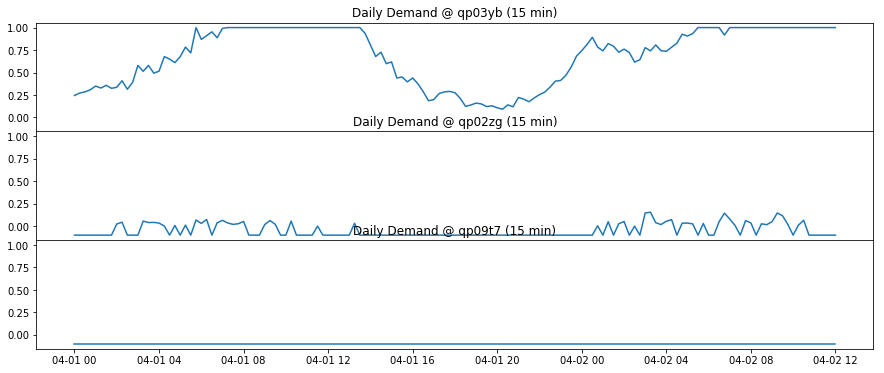

In [102]:
# Demand per location over time (15min)
# '-0.1' represents NaN value

df = df.replace(np.nan, -0.1) # visual purpose only

geohash_str_1 = 'qp03yb' # high demand
geohash_str_2 = 'qp02zg' # median
geohash_str_3 = 'qp09t7' # low demand

start_date = datetime(2019, 4, 1, 0)
end_date = datetime(2019, 4, 2, 12)
x = pd.date_range(start_date, end_date, freq="15min").values

y1 = get_timespan_15(df[df.index==geohash_str_1], start_date, end_date).values.flatten() # inclusive
y2 = get_timespan_15(df[df.index==geohash_str_2], start_date, end_date).values.flatten()
y3 = get_timespan_15(df[df.index==geohash_str_3], start_date, end_date).values.flatten()

# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3) = plt.subplots(3, sharey=True)
ax1.set_title('Daily Demand @ {} (15 min)'.format(geohash_str_1))
ax2.set_title('Daily Demand @ {} (15 min)'.format(geohash_str_2))
ax3.set_title('Daily Demand @ {} (15 min)'.format(geohash_str_3))
ax1.plot(x, y1)
ax2.plot(x, y2)
ax3.plot(x, y3)

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
f.set_figheight(6)
f.set_figwidth(15)

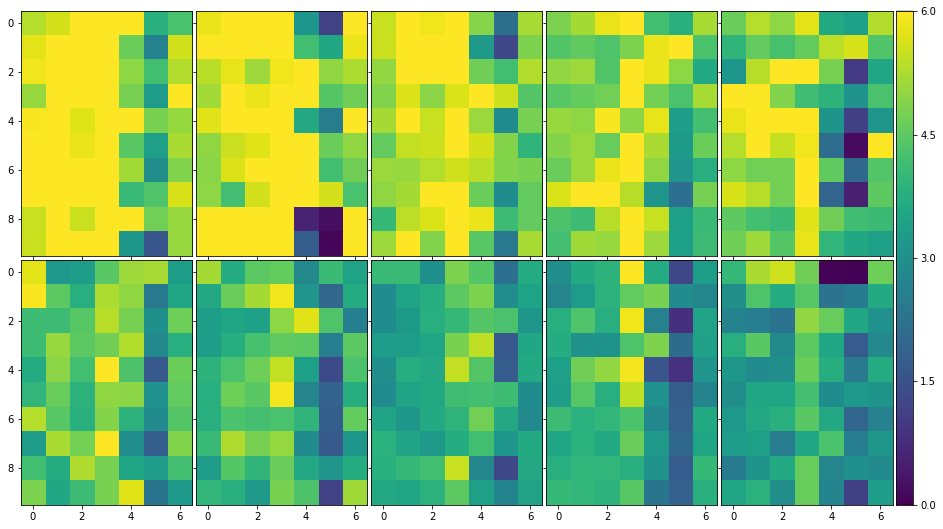

In [101]:
# Heatmap: Day of Week (DoW) vs locations

start_date = date(2019, 4, 1)
date_dict = {}
df = df.replace(-0.1, np.nan) # visual purpose only

# generate dates according to Day of Week (DoW), to procure DoW values from df_transform
for i in range(7):
    date_dict[i] = [start_date + timedelta(i) + timedelta(days=7*x) for x in range(0, math.floor(61/7)+ (i<5))]
    
df_dow = {}
for i in range(7):
    df_dow[i] = df.transpose().resample('D').sum().transpose()[date_dict[i]].sum(axis=1)  
df_dow = pd.DataFrame(df_dow)

# Single heatmap
# sns.heatmap(df_dow.sample(frac=0.01), linewidth=0.01)

# Multiple heatmaps (shows 100 locations from start Index, sorted in descending order)
row, col = 2,5
df_dow = df_dow.reindex(df_dow.sum(axis=1).sort_values(0, ascending=False).index)
start_index = 850 # Vary from 0 to 1200, to view different results. Tends to be maxed before 700
vals = [df_dow[startIndex+i*10:start_index+(i+1)*10] for i in range(row*col)]
fig = plt.figure(figsize=(16,16))
grid = AxesGrid(fig, 111,
                nrows_ncols=(row, col),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

for val, ax in zip(vals,grid):
    im = ax.imshow(val, vmin=0, vmax=max(df_dow))
grid.cbar_axes[0].colorbar(im)

plt.show()

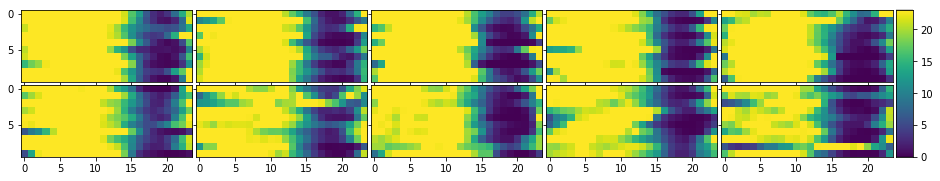

In [82]:
# Heat Map: time period (hourly) vs locations

df = df.replace(-0.1, np.nan) # visual purpose only

df_hours = {}
num_interval = 24 # split 24hrs into X intervals (e.g. 4 intervals for 6hrly)
for i in range(num_interval):
    interval = int(24/num_interval)
    start_str = str(interval*i)+':00'
    end_str = str(interval*(i+1))+':00'
    if(end_str == '24:00'): end_str = '0:00'
    df_hours[i] = df.transpose().between_time(start_str, end_str).transpose().sum(axis=1)

df_hours = pd.DataFrame(df_hours)

# Single heatmap
# sns.heatmap(df_hours.sample(frac=0.01), linewidth=0.01)

# Multiple heatmaps (shows 100 locations from start Index, sorted in descending order)
row, col = 2,5
df_hours = df_hours.reindex(df_hours.sum(axis=1).sort_values(0, ascending=False).index)
start_index = 300 # Vary from 0 to 1200, to view different results. Tends to be empty after 700
vals = [df_hours[start_index+i*10:start_index+(i+1)*10] for i in range(row*col)]
fig = plt.figure(figsize=(16,16))
grid = AxesGrid(fig, 111,
                nrows_ncols=(row, col),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

for val, ax in zip(vals,grid):
    im = ax.imshow(val, vmin=0, vmax=max(df_hours))
grid.cbar_axes[0].colorbar(im)

plt.show()